# Notebook

1. [calling Gold mask and calculating map area]()
2. [DES + GOLD catalogs]()
3. [CMASS in des catalog]() 
4. [Assigning CMASS membership probability with XD algorithm](Assigning-CMASS-membership-probability-with-XD-algorithm )

In [1]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

##### Calling Gold mask and calculating map area

In [2]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask = Cuts.limitingDepth(GoldMask, nside = 4096)
GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 50, dec=-52, dec2 = -50)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

Spatial Cut  530537
Spatial Cut  254228


##### DES + GOLD catalogs 

In [2]:
# calling gold + des catalog
merged_des_st82 = fitsio.read('result_cat/merged_des_st82.fits') # in stripe82
#merged_des_patch = fitsio.read('result_cat/merged_des_patch.fits') # spt 0<ra<50, -52<dec<-50

In [3]:
# prior Cut, limit survey depth
merged_des_st82_s, _ = priorCut( merged_des_st82 )
#merged_des_patch_s, _ = priorCut( merged_des_patch )
merged_des_st82_s = Cuts.keepGoodRegion(merged_des_st82_s)
#merged_des_patch_s = Cuts.keepGoodRegion( merged_des_patch_s )

prior cut  1565228


Check spatial map

figsave : figure/spatialtest_.png
52.0927599694 108.710042151


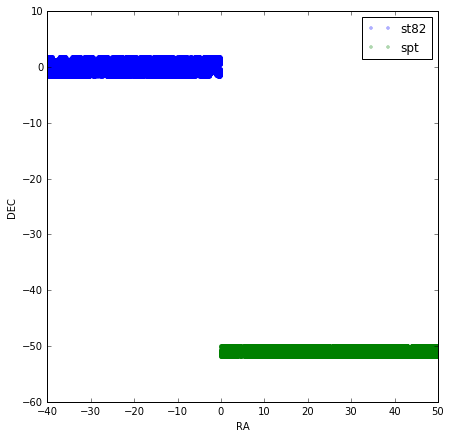

In [6]:
rows = np.random.choice(merged_des_st82_s.size, size = merged_des_st82_s.size/10)
rows2 = np.random.choice(merged_des_patch_s.size, size = merged_des_patch_s.size/10)
spatialcheck([merged_des_st82_s[rows], merged_des_patch_s[rows2]], label=['st82', 'spt'])
print SPTMaparea, ST82Maparea

In [7]:
#check number density after prior Cut
n_spt = merged_des_patch_s.size * 1./SPTMaparea
n_st82 = merged_des_st82_s.size * 1./ST82Maparea
print 'number density (patch, st82) ', n_spt, n_st82,  '  ',n_spt*1./ n_st82, '%'

number density (patch, st82)  12171.4034805 12252.4283281    0.993387037616 %


##### CMASS in des catalog 

In [4]:
# calling cmass
cmass = io.getSGCCMASSphotoObjcat()
cmass = Cuts.keepGoodRegion(cmass)
cmass = Cuts.SpatialCuts(cmass, ra=320, ra2=360, dec=-2, dec2=2)
m1, m2, _ = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], merged_des_st82_s['RA'], \
                                     merged_des_st82_s['DEC'], 1./3600, maxmatch=1)
cmass_mask = np.zeros(merged_des_st82_s.size, dtype=bool)
cmass_mask[m2] = 1
clean_cmass_data_des, nocmass = merged_des_st82_s[cmass_mask], merged_des_st82_s[~cmass_mask]

Applying Healpix BOSS SGC footprint mask
Spatial Cut  10641


##### Assigning CMASS membership probability with XD algorithm 

In [5]:
# Divide sample into train and test
(trainInd, testInd), _ = split_samples(merged_des_st82_s, merged_des_st82_s, [0.1,0.9], random_state=0)
des_train = merged_des_st82_s[trainInd]
des_test = merged_des_st82_s[testInd]

m1, m2 = esutil.numpy_util.match(clean_cmass_data_des['COADD_OBJECTS_ID'], des_train['COADD_OBJECTS_ID'])
cmass_mask = np.zeros(des_train.size, dtype=bool)
cmass_mask[m2] = 1
cmass_train, nocmass_train = des_train[cmass_mask], des_train[~cmass_mask]
print cmass_train.size, des_train.size

814 133196


In [6]:
# Fitting
pickleFileName = 'pickle/gold_st82_20_XD_cmass.pkl'
clf_cmass = XD_fitting( cmass_train, pickleFileName = pickleFileName, \
                  init_params= None,suffix = '_cmass', n_cl = 10 )
pickleFileName = 'pickle/gold_st82_20_XD_no.pkl'
rows = np.random.choice(nocmass_train.size, size=nocmass_train.size/10)                    
clf_no = XD_fitting( nocmass_train[rows], pickleFileName = pickleFileName, \
                  init_params=None, suffix = '_no', n_cl = 25 )

@pickle_results: using precomputed results from 'pickle/gold_st82_20_XD_cmass.pkl'
@pickle_results: using precomputed results from 'pickle/gold_st82_20_XD_no.pkl'


In [7]:
#rm pickle/gold_st82_21_XD_no.pkl

In [8]:
cmass_fraction = cmass_train.size * 1./des_train.size
print 'cmass_fraction', cmass_fraction
from xd import assignCMASSProb
des_test = assignCMASSProb( des_test, clf_cmass, clf_no, cmass_fraction = cmass_fraction )
des_train = assignCMASSProb( des_train, clf_cmass, clf_no, cmass_fraction = cmass_fraction )

cmass_fraction 0.00611129463347
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


save fig: com_pur_results/gold_st82_20_probability_calibration.png


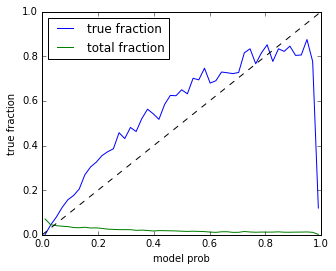

In [9]:
probability_calibration( des = des_test, cmass_des = clean_cmass_data_des, \
                        matchID= 'COADD_OBJECTS_ID', prefix = 'gold_st82_20' )

##### DMASS sampling

In [46]:
des_all = np.hstack([des_train, des_test])
dmass, _ = resampleWithPth( des_all, pstart = 0, pmax = 1.0 )
print dmass.size, clean_cmass_data_des.size

ValueError: no field of name EachProb_CMASS

writing output plot to: figure/gold_st82_20_all_diagnostic_histograms_1d.png
writing output plot to: figure/gold_st82_20_dmass_diagnostic_histograms_1d.png


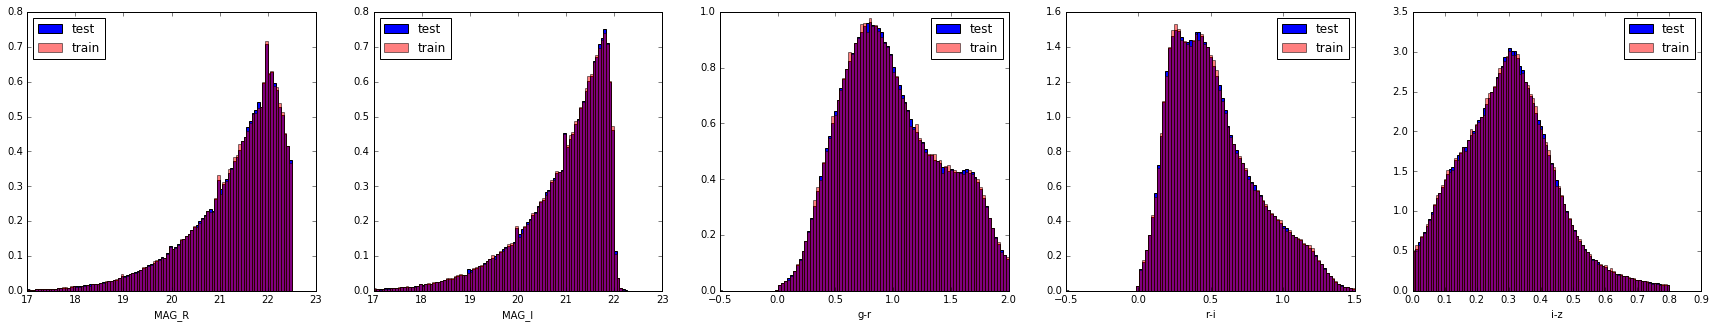

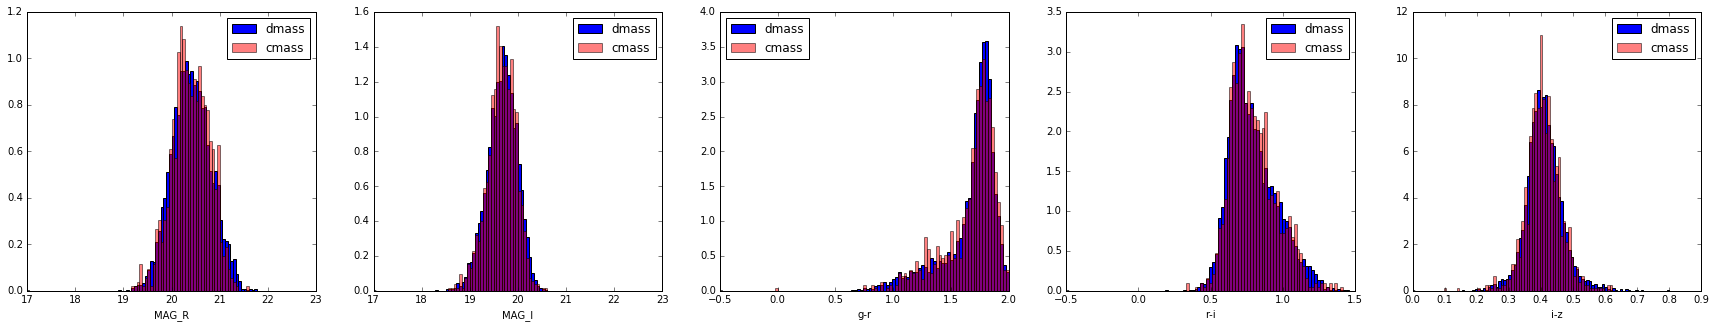

In [199]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-.5,1.5], [0.0,.8]]

X_train, Xcov_train = mixing_color(des_train)
X_test,_ = mixing_color(des_test)
doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges,\
                         name =['train','test' ], nbins=100, prefix='gold_st82_20_all_')
# Plotting dmass
X_cmass,_ = mixing_color(cmass_train)
X_dmass,_ = mixing_color(dmass)
doVisualization_1d( X_cmass, X_dmass,  labels = labels, ranges = ranges,\
                         name =['cmass','dmass' ], nbins=100, prefix='gold_st82_20_dmass_')

----

##### Error convolved distribution

In [47]:
cmass_model = clf_cmass.sample(cmass_train.size)
no_model = clf_no.sample(nocmass_train.size)

X_train, Xcov_train = mixing_color(des_train)
X_test,_ = mixing_color(des_test)

noisy_cmass_model = add_errors_multiprocessing(cmass_model, X_train[cmass_mask], Xcov_train[cmass_mask])
nosiy_no_model = add_errors_multiprocessing(no_model, X_train[~cmass_mask], Xcov_train[~cmass_mask])

add noise to sample 100 %
add noise to sample 100 %


writing output plot to: figure/model_cmass_diagnostic_histograms_1d.png
writing output plot to: figure/model_no_diagnostic_histograms_1d.png


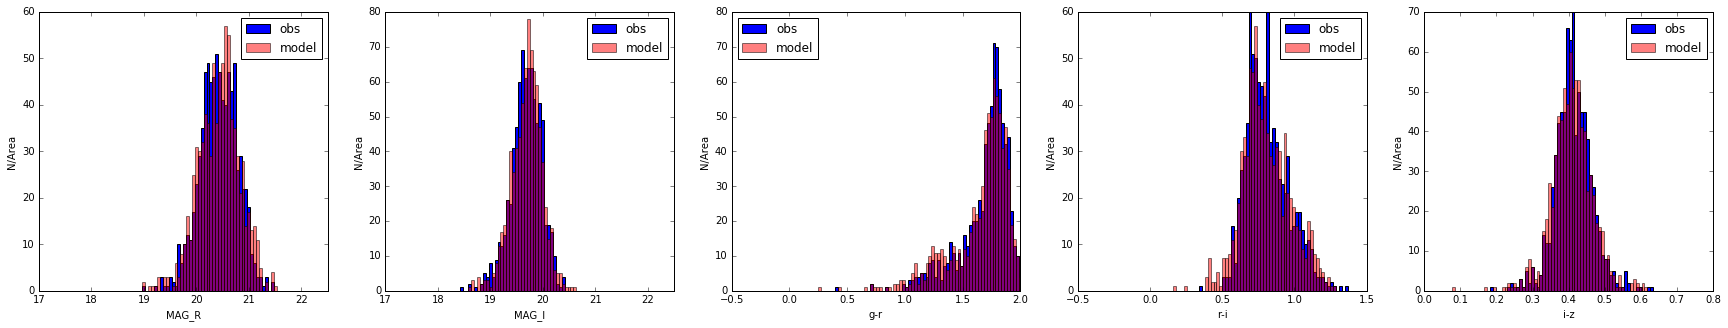

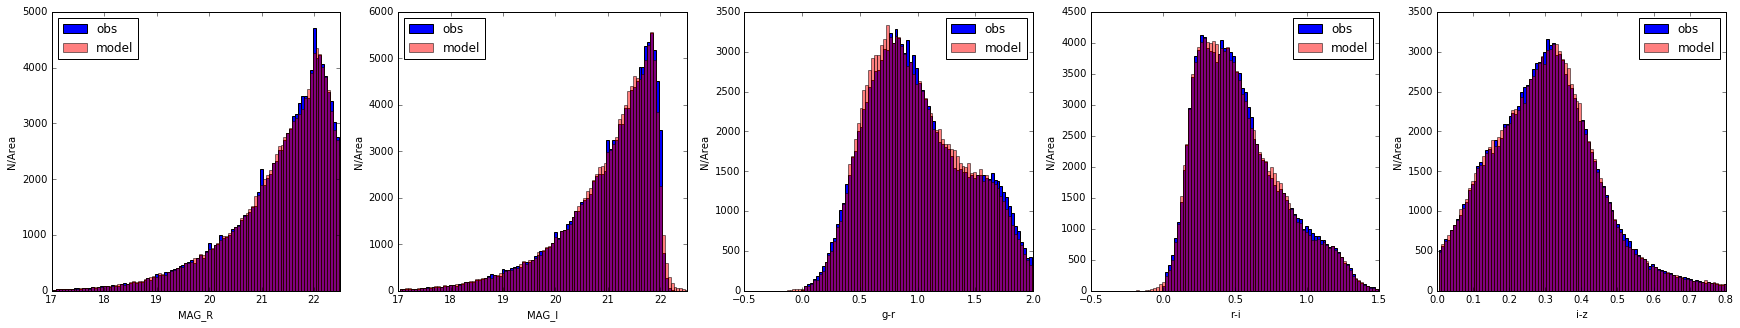

In [48]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-.5,2], [-.5,1.5], [0.0,.8]]
doVisualization_1d_NperA( noisy_cmass_model, X_train[cmass_mask], area=[1,1], labels = labels, ranges = ranges,\
                         name =['model','obs' ], nbins=100, prefix='model_cmass_')
doVisualization_1d_NperA( nosiy_no_model, X_train[~cmass_mask], area=[1,1], labels = labels, ranges = ranges,\
                         name =['model','obs' ], nbins=100, prefix='model_no_')

##### underlying distribution

In [195]:
# Fitting
pickleFileName = 'pickle/gold_st82_21_XD_all.pkl'
rows = np.random.choice(des_train.size, size=int(des_train.size /10.)) 
clf_all = XD_fitting( des_train[rows], pickleFileName = pickleFileName, \
                  init_params= 'pickle/gold_st82_21_XD_no.pkl', suffix = '_all1', n_cl = 25 )
pickleFileName = 'pickle/gold_st82_21_XD_all_patch.pkl'
rows = np.random.choice(merged_des_patch_s.size, size=int(merged_des_patch_s.size /50.))                    
clf_all2 = XD_fitting( merged_des_patch_s[rows], pickleFileName = pickleFileName, \
                  init_params= 'pickle/gold_st82_21_XD_no.pkl', suffix = '_all2', n_cl = 25 )

@pickle_results: using precomputed results from 'pickle/gold_st82_21_XD_all.pkl'
@pickle_results: using precomputed results from 'pickle/gold_st82_21_XD_all_patch.pkl'


In [192]:
#rm pickle/gold_st82_21_XD_all.pkl pickle/gold_st82_21_XD_all_patch.pkl

writing output plot to: figure/model_diagnostic_histograms_1d.png


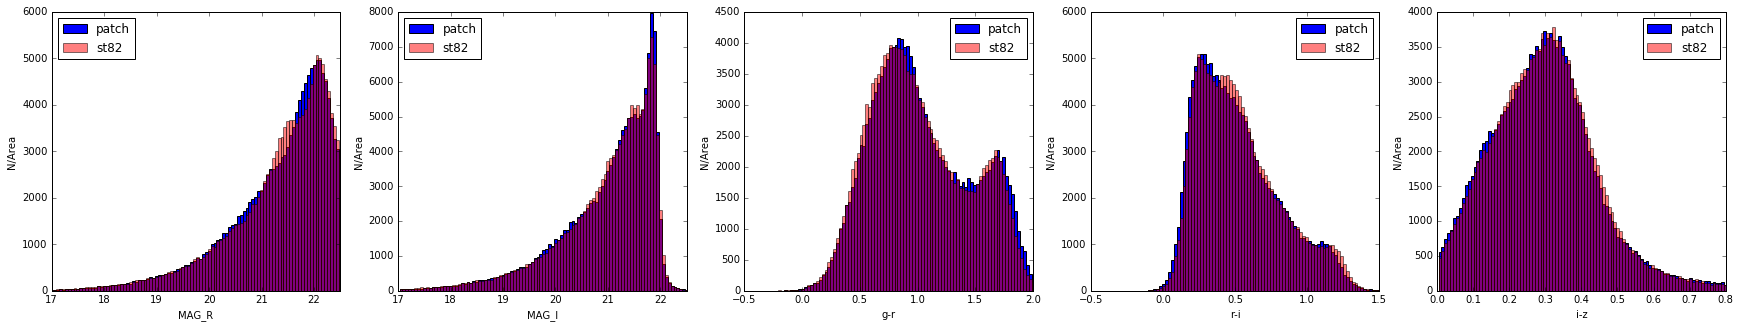

In [196]:
clean_all = clf_all.sample(des_train.size)
clean_all2 = clf_all2.sample(des_train.size)

labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-.5,2], [-.5,1.5], [0.0,.8]]
doVisualization_1d_NperA( clean_all, clean_all2, area=[1,1], labels = labels, ranges = ranges,\
                         name =['st82','patch' ], nbins=100, prefix='model_')

## To do

- [ ] Buz same area test
- [ ] add extra noise and see XD can recover underlying dist
- [ ] repeat multiple times (buz) 

##### Add extra noise 

----

## 1. g-r number density difference

In [7]:
# calling all gold catalogue
des_gold = io.getDESY1A1catalogs(keyword = 'Y1A1_GOLD_merged', gold=True)

Y1A1_GOLD_merged_01.fits
Y1A1_GOLD_merged_02.fits
Y1A1_GOLD_merged_03.fits
Y1A1_GOLD_merged_04.fits
Y1A1_GOLD_merged_05.fits
Y1A1_GOLD_merged_06.fits
Y1A1_GOLD_merged_07.fits
Y1A1_GOLD_merged_08.fits
Y1A1_GOLD_merged_09.fits
Y1A1_GOLD_merged_10.fits
Y1A1_GOLD_merged_11.fits
Y1A1_GOLD_merged_12.fits
Y1A1_GOLD_merged_13.fits
Y1A1_GOLD_merged_14.fits
Y1A1_GOLD_merged_15.fits
Y1A1_GOLD_merged_16.fits
Y1A1_GOLD_merged_17.fits
Y1A1_GOLD_merged_18.fits
Y1A1_GOLD_merged_19.fits
Y1A1_GOLD_merged_20.fits


MemoryError: 

In [6]:
des_gold = des_gold[des_gold['MODEST_CLASS'] == 1]

In [19]:
# reddening correction : 
mags = ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO','MAG_APER_3', 'MAG_APER_4', 'MAG_APER_5', 'MAG_APER_6']
des_gold = getCorrectedMag( des_gold, mags = mags, reddening = None )
des_gold_s, _ = priorCut(des_gold)

prior cut  25372986


/usr/lib64/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [28]:
# reddening correction : 
#mags = ['MAG_APER_3', 'MAG_APER_4', 'MAG_APER_5', 'MAG_APER_6']
#des_gold_s = getCorrectedMag( des_gold_s[0], mags = mags, reddening = None )

In [31]:
des_gold = 0
des_gold_s = Cuts.doBasicCuts(des_gold_s, raTag = 'RA', decTag='DEC', object = None)

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
no object selected. retrieve star + galaxy both
do Basic Cut 20089187


----

#### Density Estimation

In [34]:
# testing for same area of des_gold 
def getHealInd_rot(ra, dec, nside = 8):
    rmat = np.array([ 0.382192, 0.054546, 0.922472,\
                     -0.924079, 0.025571, 0.381346,\
                     -0.002787, -0.998184, 0.060177 ]).reshape(3,3)
    vec  = hp.ang2vec(-(dec - 90.) * np.pi / 180., ra * np.pi / 180.)
    rvec = np.dot(np.linalg.inv(rmat), vec.T)
    pix  = hp.vec2pix(nside, *rvec, nest=False)
    return pix

In [42]:
# calling y1a1 gold 
gold_y1a1 = None
gold_y1a1 = io.getDESY1A1catalogs(keyword = 'Y1A1_GOLD_merged_2', gold=True)
mags = ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']
gold_y1a1 = getCorrectedMag( gold_y1a1, mags = mags, reddening = None )
mags = ['MAG_APER_3', 'MAG_APER_4', 'MAG_APER_5', 'MAG_APER_6']
gold_y1a1 = getCorrectedMag( gold_y1a1, mags = mags, reddening = None )
gold_y1a1 = Cuts.doBasicCuts(gold_y1a1, raTag = 'RA', decTag='DEC', object = None)
gold_y1a1 = Cuts.keepGoodRegion(gold_y1a1)
gold_y1a1,_ = priorCut(gold_y1a1)

Y1A1_GOLD_merged_20.fits
no object selected. retrieve star + galaxy both
do Basic Cut 1395140
prior cut  35413


In [43]:
Hpix = [119, 120, 151 ,152 ,153,182, 183 ,184 ,185]
Hpix8 = getHealInd_rot( gold_y1a1['RA'], gold_y1a1['DEC'], nside = 8)

In [36]:
"""
gold_y1a1_list = []
for p in Hpix:
    mask = (Hpix8 == p)
    cat = gold_y1a1[mask]
    #cat = priorCut(cat)
    #cat = Cuts.keepGoodRegion(cat)
    gold_y1a1_list.append(cat)
    cat = None
"""

In [41]:
"""
gold_y1a1_list2 = []
for p in Hpix:
    mask = Hpix8 == p
    cat = gold_y1a1[mask]
    #cat = priorCut(cat)
    #cat = Cuts.keepGoodRegion(cat)
    gold_y1a1_list2.append(cat)
    cat = None
"""

In [44]:
gold_y1a1_list3 = []
for p in Hpix:
    mask = Hpix8 == p
    cat = gold_y1a1[mask]
    #cat = priorCut(cat)
    #cat = Cuts.keepGoodRegion(cat)
    gold_y1a1_list3.append(cat)
    cat = None

In [46]:
#combine
gold_y1a1_list_com = []
for i in np.arange(len(Hpix)):
    combine = np.hstack([gold_y1a1_list[i], gold_y1a1_list2[i],gold_y1a1_list3[i]])
    gold_y1a1_list_com.append(combine)

In [56]:
gold_y1a1_list = None
gold_y1a1_list2 = None
gold_y1a1_list3 = None

In [51]:
# calculate num density

num_d = []
for i, p in enumerate(Hpix):
    test_area = getHPArea(pix = p)
    nd = gold_y1a1_list_com[i].size/test_area
    num_d.append(nd)

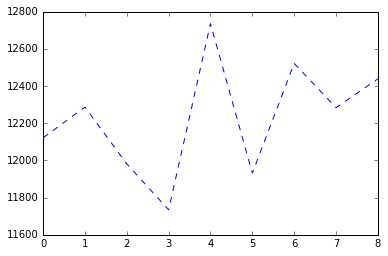

In [55]:
nd_cmass = 1

fig, ax = plt.subplots()
ax.plot(np.arange(len(Hpix)), np.array(num_d)/nd_cmass, '--')
#ax.axhline(y = 1, color='grey', linestyle='--')
